In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Process for 1D functions

This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are defined by f(x) = a * sin(x - b) where a and b and randomly sampled.

### Visualize Data

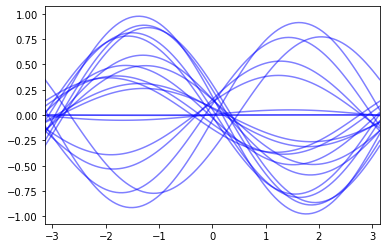

In [2]:
from lib.datasets.datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)
#2000 different sine functions
#each function have 100 points

# Visualize data samples
for i in range(20):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Build Neural Process

In [3]:
from lib.core.neural_process import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

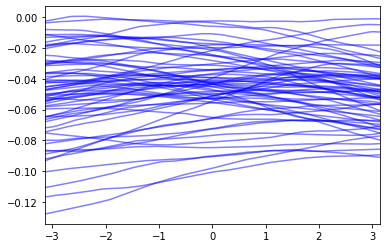

In [4]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Train Neural Process

In [5]:
from torch.utils.data import DataLoader
from lib.core.training import NeuralProcessTrainer

batch_size = 2
num_context = 99
num_target = 1

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 30)


Epoch: 0, Avg_loss: 48.335454513423144
Epoch: 1, Avg_loss: 21.458180553548036
Epoch: 2, Avg_loss: 19.67802462184429
Epoch: 3, Avg_loss: -34.22717560407519
Epoch: 4, Avg_loss: -77.55524608896673
Epoch: 5, Avg_loss: -105.56651516103744
Epoch: 6, Avg_loss: -118.4906838760376
Epoch: 7, Avg_loss: -123.73447299432755
Epoch: 8, Avg_loss: -125.35990524673461
Epoch: 9, Avg_loss: -126.53525362205505
Epoch: 10, Avg_loss: -128.14730407714845
Epoch: 11, Avg_loss: -127.22351648330688
Epoch: 12, Avg_loss: -129.14484466934204
Epoch: 13, Avg_loss: -127.68905823898315
Epoch: 14, Avg_loss: -130.15425943756102
Epoch: 15, Avg_loss: -130.0701844444275
Epoch: 16, Avg_loss: -130.86006692504884
Epoch: 17, Avg_loss: -130.83422427368163
Epoch: 18, Avg_loss: -130.7303545074463
Epoch: 19, Avg_loss: -131.30456148529052
Epoch: 20, Avg_loss: -131.1649951400757
Epoch: 21, Avg_loss: -131.02057786178588
Epoch: 22, Avg_loss: -131.4645969924927
Epoch: 23, Avg_loss: -131.11941971588135
Epoch: 24, Avg_loss: -132.73914467620

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

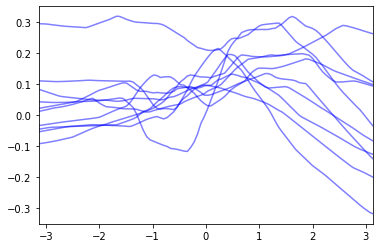

In [8]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(10):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Visualize samples from posterior

torch.Size([1, 2, 1])
torch.Size([1, 20, 1])
torch.Size([1, 50, 1])


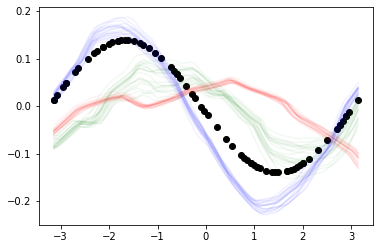

In [20]:
from lib.utils.utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
# x,y here just the first sample in the dataset
# the final result will show that it will be very close to the sample in the dataset
# since we use this sample as context(observed data)
num_context = 2

x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)
print(x_context.size())
# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(20):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='r')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')

num_context = 20

x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)
print(x_context.size())
# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(20):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='g')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')

num_context = 50

x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)
print(x_context.size())
# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(20):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')
